**Question 1**
* Gabriel Cutshaw
* Dante Goldner
* Mattan Tseng
* Hossen Zaremehrjerdi


In [20]:
import numpy as np
import h5py
from einops import rearrange
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import time
import datetime
from torchmetrics.classification import BinaryAccuracy

print(torch.__version__)


2.0.0+cu117


In [2]:
data_path = "./Combustion_data_ME592_Assignment/Aditya_data/combustion_img_13.mat"
arrays = {}


data = h5py.File(data_path)

for k, v in data.items():
    arrays[k] = np.array(v)


test_set_x = arrays["test_set_x"]
test_set_y = arrays["test_set_y"]
train_set_x = arrays["train_set_x"]
train_set_y = arrays["train_set_y"]
valid_set_x = arrays["valid_set_x"]
valid_set_y = arrays["valid_set_y"]

In [3]:
print(type(arrays))
#print(arrays)

print("The shape of test x: ", test_set_x.shape)
print("The shape of test y: ", test_set_y.shape)
print("The shape of train x: ", train_set_x.shape)
print("The shape of train y: ", train_set_y.shape)
print("The shape of validation x: ", valid_set_x.shape)
print("The shape of validation y: ", valid_set_y.shape)

<class 'dict'>
The shape of test x:  (25000, 18000)
The shape of test y:  (18000, 1)
The shape of train x:  (25000, 54000)
The shape of train y:  (54000, 1)
The shape of validation x:  (25000, 9000)
The shape of validation y:  (9000, 1)


shape of test array:  (18000, 100, 250)
shape of train array:  (54000, 100, 250)
shape of validation array:  (9000, 100, 250)
This image is labeled:  [1]  (stable)


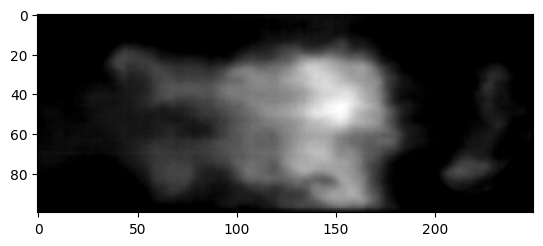

In [4]:
image_shape = (250, 100)

# all of our arrays are strangely formatted. 
# rearrange them to be individual images. 

# test set is not used at all in training. 
test_images = rearrange(test_set_x, "(x y) i -> i y x", x = image_shape[0], y = image_shape[1])
# train set is used to actually train the model
train_images = rearrange(train_set_x, "(x y) i -> i y x", x = image_shape[0], y = image_shape[1])
# train_labels = rearrange(train_set_y, "x y -> y x")
# validation set is used to avoid overfitting 
validation_images = rearrange(valid_set_x, "(x y) i -> i y x", x = image_shape[0], y = image_shape[1])
print("shape of test array: ", test_images.shape)
print("shape of train array: ", train_images.shape)
print("shape of validation array: ", validation_images.shape)


plt.imshow(train_images[0, :, :], cmap="gist_gray")
print("This image is labeled: ", test_set_y[0], " (stable)")

# plt.imshow(np.zeros((10, 10)), cmap="Greys")


This image is labeled:  [0]  (unstable)
0
255


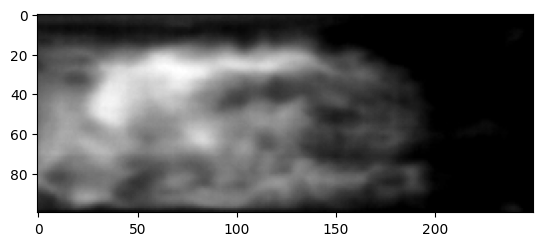

In [5]:
plt.imshow(test_images[2000, :, :], cmap='gist_gray')
print("This image is labeled: ", test_set_y[2000], " (unstable)")
print(np.min(test_images[2000, :, :]))
print(np.max(test_images[2000, :, :]))

Text(0, 0.5, 'instances')

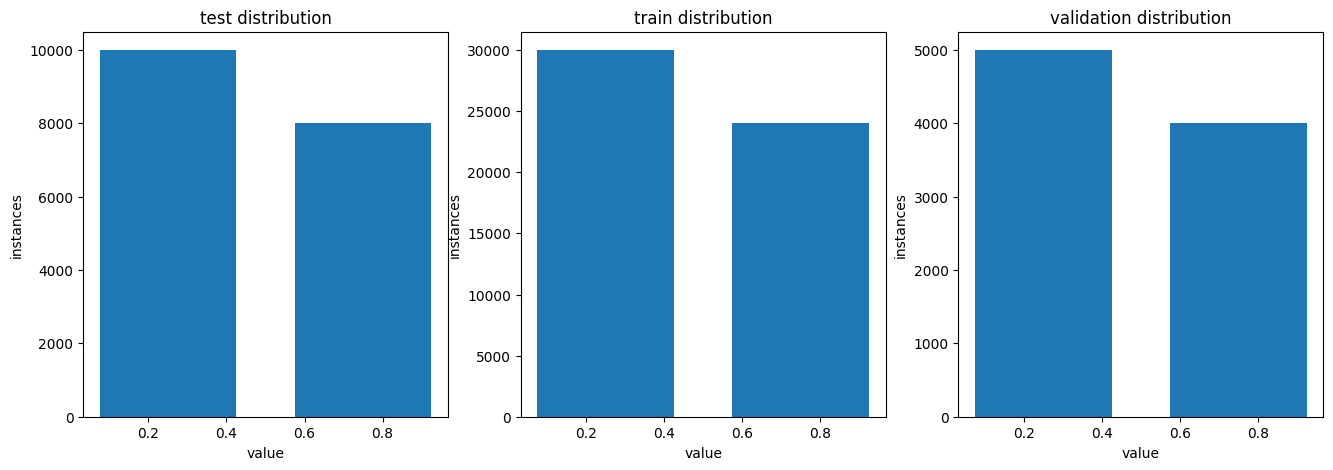

In [6]:
fig, ax = plt.subplots(1, 3, figsize = (16, 5))
ax[0].set_title("test distribution")
ax[0].hist(test_set_y, bins = 2, rwidth = 0.7)
ax[0].set_xlabel("value")
ax[0].set_ylabel("instances")

ax[1].set_title("train distribution")
ax[1].hist(train_set_y, bins = 2, rwidth = 0.7)
ax[1].set_xlabel("value")
ax[1].set_ylabel("instances")


ax[2].set_title("validation distribution")
ax[2].hist(valid_set_y, bins = 2, rwidth = 0.7)
ax[2].set_xlabel("value")
ax[2].set_ylabel("instances")


In [8]:
# Define the CNN architecture

# These links were used for reference 
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/
# for a test, let's train this first without using the validation set. 
# that way we can prove that the validation set actually does help increase accuracy and decrease overfitting
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2,2)
        # self.fc1 = nn.Linear(800, 64)
        self.fc1 = nn.Linear(89792, 1000)
        self.fc2 = nn.Linear(1000, 2)


    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))

        # num_flat_features = x.size(1)*x.size(2)*x.size(3)
        # x = x.view(-1, num_flat_features)

        x = torch.flatten(x, 1) # flatten all dimensions except batch

        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x




In [9]:
# Define the training loop
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# Define the validation loop
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    val_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, accuracy

# Define the test loop
def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy


In [13]:
# now that our data preparation is complete, we can start setting up our CNN
# Input: Image
# Output: Stable/Unstable (1 or 0)

# these are the hyperparameters for the model
# remember that a batch is how many items the  model will train on before updating the model
batch_size = 4
# remember that an epoch is the number of times that the trainer will go through the entire dataset
epochs = 1 
# since our image is rectangular, let's use a rectangular kernel. 
# this touple is comprised of factors of the dimensions. 
kernel_size = (25, 10) 
input_height = train_images[0].shape[0]
input_width = train_images[0].shape[1]


stride = 1
classes = ("stable", "unstable")
number_channels = 1 # this is a grayscale image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# to increase the speed of the training, make sure that the GPU is being used. 
print(torch.cuda.is_available())


print("Number of epochs: ", epochs)
print("Batch size: ", batch_size)
print("Kernel size: ", kernel_size)
print("Stride size: ", stride)
print("Classes: ", classes)
print("input height: ", input_height)
print("input width: ", input_width)
print("device type: ", device)
# print("The device being used is: ", device)

True
Number of epochs:  1
Batch size:  4
Kernel size:  (25, 10)
Stride size:  1
Classes:  ('stable', 'unstable')
input height:  100
input width:  250
device type:  cuda


In [15]:
train_images_torch = torch.div(torch.from_numpy(train_images).float(), 255)
train_labels_torch = torch.from_numpy(train_set_y).float()
train_dataset = torch.utils.data.TensorDataset(train_images_torch, train_labels_torch)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)



validation_images_torch = torch.div(torch.from_numpy(validation_images).float(), 255)
validation_labels_torch = torch.from_numpy(valid_set_y).float()
validation_dataset = torch.utils.data.TensorDataset(validation_images_torch, validation_labels_torch)
validation_loader =  torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=6)

# test_images_torch = torch.div(torch.from_numpy(test_images).float(), 255)
# test_labels_torch = torch.from_numpy(test_set_y).float()
# validation_images_torch = torch.div(torch.from_numpy(validation_images).float(), 255)
# validation_labels_torch = torch.from_numpy(valid_set_y).float()
# create the dataloaders from our tensors. 
# train_loader = torch.utils.data.TensorDataset(train_images_torch, train_set_y)
# val_loader = torch.utils.data.TensorDataset(validation_images_torch, validation_labels_torch)
# test_loader = torch.utils.data.TensorDataset(test_images_torch, test_labels_torch)
# val_loader = torch.utils.data.DataLoader(val_loader, batch_size=batch_size, shuffle=False, num_workers=6) 
# test_loader = torch.utils.data.DataLoader(test_loader, batch_size=batch_size, shuffle=False, num_workers=6)
cnn = CNN()
cnn.to(device)
print(cnn)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

start_time = time.time()
training_losses = []
validation_losses = []
for epoch in range(epochs):
    # set the model to training mode
    cnn.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        inputs = rearrange(inputs, "(c b) h w -> b c h w", c = 1)
        # zero the parameter gradients
        optimizer.zero_grad()

        # run the training data through the model
        outputs = cnn(inputs)
        #calculate the loss of the model
        loss = criterion(outputs, torch.max(labels, 1)[1])

        # print statistics
        running_loss += loss.item()
        
        if i % 1000 == 999:    # print every 2000 mini-batches
            validation_running_loss = 0.0
            for v, vdata in enumerate(validation_loader):
                cnn.eval()
                vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
                vinputs = rearrange(vinputs, "(c b) h w -> b c h w", c = 1)
                voutputs = cnn(vinputs)
                vloss = criterion(voutputs, torch.max(vlabels, 1)[1])
                validation_running_loss += vloss.item()
            

            print("epoch: ", epoch+1, "batch: ", i+1, "Loss: ", running_loss, "\tValidation loss: ", validation_running_loss)
            validation_losses.append(validation_running_loss)
            training_losses.append(running_loss)
            running_loss = 0.0
        

        # once the validation has been completed, update the model
        loss.backward()
        optimizer.step()
        # set model back to training mode
        cnn.train()



end_time = time.time()
train_time = end_time - start_time
print("Elapsed Training Time: ", datetime.timedelta(seconds = train_time))
print('Finished Training')

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89792, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=2, bias=True)
)
epoch:  1 batch:  1000 Loss:  3.47866914162978 	Validation loss:  0.079452319426764
epoch:  1 batch:  2000 Loss:  0.02481911053928343 	Validation loss:  0.04664835748258156
epoch:  1 batch:  3000 Loss:  0.015807673220820107 	Validation loss:  0.03263486473542798
epoch:  1 batch:  4000 Loss:  0.011825483116581381 	Validation loss:  0.024748002350179377
epoch:  1 batch:  5000 Loss:  0.009641114734222356 	Validation loss:  0.019666601650556004
epoch:  1 batch:  6000 Loss:  0.007670445370706602 	Validation loss:  0.016290234345660792
epoch:  1 batch:  7000 Loss:  0.006215731437748673 	Validation loss:  0.013939639922682545
epoch:  1 batch:  8000 Loss:  0.00

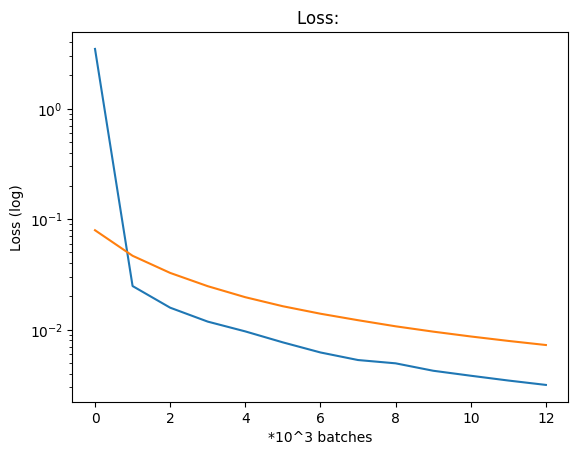

In [17]:

plt.title("Loss: ")
plt.xlabel("*10^3 batches")
plt.ylabel("Loss (log)")
plt.yscale("log")
plt.plot(training_losses)
plt.plot(validation_losses)


In [32]:
# now that the training has been completed, run through the test set.
test_images_torch = torch.div(torch.from_numpy(test_images).float(), 255)
test_labels_torch = torch.from_numpy(test_set_y).float()
test_dataset = torch.utils.data.TensorDataset(test_images_torch, test_labels_torch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=6)

test_losses = []

test_accuracy = []

binaryacc = BinaryAccuracy()

for i, test_data in enumerate(test_loader):
    cnn.eval()
    test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)
    test_inputs = rearrange(test_inputs, "(c b) h w -> b c h w", c = 1)
    test_outputs = cnn(test_inputs)
    test_loss = criterion(test_outputs, torch.max(test_labels, 1)[1])
    test_losses.append(test_loss.item())

    print(test_outputs)

    print("*"*50)
    print(torch.max(test_labels, 1)[1])
    print(torch.max(test_labels, 1))
    print(test_labels)

    test_accuracy.append(binaryacc(test_outputs,test_labels))

test_losses = np.asarray(test_losses)

print("Loss mean of test: ", test_losses.mean())
print("Max loss of test: ", test_losses.max())
print("Min loss of test: ", test_losses.min())


tensor([[ 6.9624, -6.4666],
        [ 7.2378, -6.7173],
        [ 6.9078, -6.4092],
        [ 7.6019, -7.0593]], device='cuda:0', grad_fn=<AddmmBackward0>)
**************************************************
tensor([0, 0, 0, 0], device='cuda:0')
torch.return_types.max(
values=tensor([1., 0., 1., 0.], device='cuda:0'),
indices=tensor([0, 0, 0, 0], device='cuda:0'))
tensor([[1.],
        [0.],
        [1.],
        [0.]], device='cuda:0')


RuntimeError: Predictions and targets are expected to have the same shape, but got torch.Size([4, 2]) and torch.Size([4, 1]).